# Dynamic inflow

## Dynamic wind speed and direction in the DWMFlowSimulation setup

When running the `DWMFlowSimulation` with a `TurbulenceFieldSite`, the wind speed and direction is constructed from

- The turbulent fluctuations, $f(x,y,z,t) \rightarrow u,v,w$ in the turbulence field
- A function providing the mean wind speed including shear etc, $f(x,y,z,t) \rightarrow U,V,W$

In addition there are two important and related concepts, `wind_direction` and `turbulence_transport_speed` which controls the advection direction and speed of the turbulence field.

The turbulence transport speed, $U_{Transport}$ is used to map time and position to position via Taylor's frozen turbulence hypothesis extended support changing transport speed: $f(x,y,z,t) \rightarrow turb(x+\int_t{U_{Transport}(t)},y,z) \rightarrow u,v,w$. 

`wind_direction` is a property of `FlowSimulation`. It controls the angle between North and the $-x$-axis (where the wind comes from). Internally, this is done by rotating the wind farm such that the turbulence transport direction is always in the $x$ direction.

![wind direction](x_north_winddirection.svg)

Stocastic turbulent variations with frequencies < 10min are modeled in e.g. Mann turbulence model (while stocastic variations with lower frequencies requires additional models)

Deterministic changes in the wind direction and wind speed can be modelled in three more or less bad ways:

- [Add changes to the turbulence field](#Add-changes-to-the-turbulence-field)
- [Add changes via the mean wind speed function](#Add-changes-via-the-mean-wind-speed-function)
- [Change the transport speed and direction](#Change-the-transport-speed-and-direction)

But it may be possible to combine the methods in a more appropiate way, see [Modeling a time series of wind direction and speed](#Modeling-a-time-series-of-wind-direction-and-speed)


In [2]:
from dynamiks.utils import doc_utils # use cached animations in sphinx documentation
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation, DemoSite
from dynamiks.sites.turbulence_fields import MannTurbulenceField
from dynamiks.visualizers.flow_visualizers import Flow2DVisualizer
from dynamiks.dwm.particle_motion_models import ParticleMotionModel, XSpeed
from dynamiks.visualizers import WindDirectionVisualizer, ParticleVisualizer
from dynamiks.sites import TurbulenceFieldSite
from dynamiks.sites._site import UniformSite
from dynamiks.sites.mean_wind import MeanWind
from dynamiks.utils.test_utils import tfp
from dynamiks.utils.data_dumper import DataDumper
from dynamiks.views import XYView, EastNorthView, MultiView, View
from dynamiks.utils.geometry import get_east_north_height

import numpy as np
from numpy import newaxis as na
from py_wake.utils.plotting import setup_plot
import matplotlib.pyplot as plt

wd_x,wd_y = [v.flatten() for v in np.meshgrid([-400,0,400],[-400,0,400])]
def get_visualizers(ax=None):
    ax = ax or plt.gca()
    return [WindDirectionVisualizer(wd_x,wd_y,70, 5), 
            ParticleVisualizer(), 
            lambda fs,ax=ax:ax.set_title(f'Time: {fs.time:.0f}s, WD: {wd(fs.time):.0f} deg, WS: {ws(fs.time):.0f}m/s')]

In the examples below we will change the wind direction from 270 to 300deg and the wind speed from 5 to 10m/s during 300s of simulation

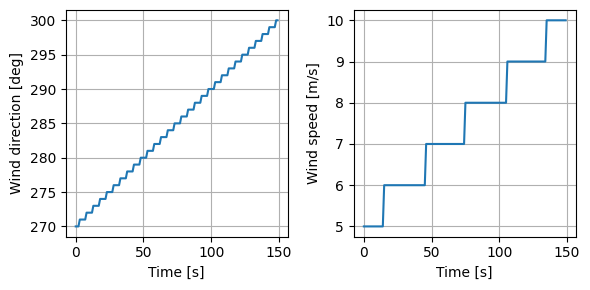

In [3]:
def wd(time):
    return np.round(270+time/5)
def ws(time):
    return np.round(5 + time/30)

t = np.arange(0,150)
ax1,ax2 = plt.subplots(1,2,figsize=(6,3))[1]
ax1.plot(t,wd(t))
setup_plot(xlabel='Time [s]', ylabel='Wind direction [deg]', ax=ax1)
ax2.plot(t,ws(t))
setup_plot(xlabel='Time [s]', ylabel='Wind speed [m/s]', ax=ax2)

## Add changes to the turbulence field

In this example, the change in wind direction and wind speed are modeled by adding the mean wind to the u and v turbulence field components.

In the simulation below, the particles advect with the low-pass filtered local velocity and wake deflection due to yaw misalignment is ignored.

In [4]:
site = DemoSite(ws=10, ti=0.05)
i = np.arange(312,1000)
x2time = (2500-i*3.2)/10
theta = np.deg2rad(270-wd(x2time))

site.turbulenceField.uvw[0,i] += (np.cos(theta)*ws(x2time))[:,na,na]-10
site.turbulenceField.uvw[1,i] += (np.sin(theta)*ws(x2time))[:,na,na]

fs = DefaultDWMFlowSimulation(site=site, particleMotionModel=ParticleMotionModel(x_speed=XSpeed.Particle), d_particle=0.5, n_particles=100)
fs.visualize(150, dt=1, interval=.1, id='MeanFlowVariations_ch_turb',
             view=XYView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                         flowVisualizer=Flow2DVisualizer(levels=np.linspace(0,12,25)),
                         visualizers=get_visualizers()))

**Observations**:

- Mean flow changes are propagated through the domain with the constant turbulence transport speed, $U_{Transport}$
- Mismatch between advection direction and speed of turbulence structures and wake particles.
  - Turbulence structures advected along the x axis with the turbulence transport speed, $U_{Transport}$
  - Wake partikles advected with the local wind direction and speed (temporal and/or spatially filtered)
- The turbulence intensity diverges from the specified value when the mean wind speed changes
- The relation between $\sigma(u)$, $\sigma(v)$ and $\sigma(w)$ that is prescribed by the turbulence model will be distorted when the mean wind direction is not aligned with $u$.
- The linear shear in the $(u,w)$ plane of the of Mann model points in the wrong direction when the mean wind direction is not aligned with $u$.
- The wind turbine does not yaw to face the wind. An explicit yaw control mechanism is needed

**Conclusion**:

- This method should only be used for small changes in wind direction and speed.
- Wind turbines do not face the wind, i.e. a yaw controller (and actuator) is needed

## Add changes via the mean wind speed function

In this example, the change in wind direction and wind speed are modeled by the mean wind speed function.

In the simulation below, the particles advect with the low-pass filtered local velocity and wake deflection due to yaw misalignment is ignored.


In [5]:
from dynamiks.sites.mean_wind import MeanWind
class MyMeanWind(MeanWind):
    def __call__(self, xyz, uvw, time):
        theta = np.deg2rad(270-wd(time))
        uvw[0]+=np.cos(theta)*ws(time)
        uvw[1]+=np.sin(theta)*ws(time)
        return uvw
        

site = DemoSite(ws=MyMeanWind(ws=10), ti=0.05)
fs = DefaultDWMFlowSimulation(site=site, particleMotionModel=ParticleMotionModel(x_speed=XSpeed.Particle), d_particle=0.5, n_particles=100)

fs.visualize(150, dt=1, interval=.1, id='MeanFlowVariations_ch_mean',
             view=XYView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                         flowVisualizer=Flow2DVisualizer(levels=np.linspace(0,12,25)),
                         visualizers=get_visualizers()))

**Observations**:

- Same as [Add changes to the turbulence field](#Add-changes-to-the-turbulence-field) except that changes can be applied to the whole domain instantaneously or propagated in a custom way depending on the implementation of the mean wind speed function.

**Conclusion**:

- This method should only be used for small changes in wind direction and speed.
- Wind turbines do not face the wind, i.e. a yaw controller (and actuator) is needed

## Change the transport speed and direction

In this example, the changes in wind direction are modeled by changing the `wind_direction` property that controls the angle between North and the $-x$-axis (where the wind comes from). This is done by rotating the wind farm such that the turbulence transport direction is always in the $x$ direction as seen in the right figure.

The changes in wind speed are modeled by the mean wind speed function and in addition also the turbulence transport speed is changed.

The left visualization plot shows the simulation in fixed East-North space, while the right plots shows the simulation in fixed $x$-$y$ space.

In [6]:
from dynamiks.sites.mean_wind import MeanWind
def transport_changer(flowSimulation):
    flowSimulation.wind_direction=wd(flowSimulation.time)
    flowSimulation.site.turbulence_transport_speed = ws(flowSimulation.time)
    flowSimulation.site.add_mean_windspeed.ws = ws(flowSimulation.time)
        
fs = DefaultDWMFlowSimulation(x=[-200,200],y=[0,0],ws=5, ti=.05, particleMotionModel=ParticleMotionModel(x_speed=XSpeed.Particle),
                              d_particle=0.5, n_particles=50, step_handlers=[transport_changer])

axes = plt.subplots(1,2,figsize=(10,5))[1]
fs.visualize(150, dt=2, interval=1, id='MeanFlowVariations_ch_dir',
             view=MultiView([EastNorthView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                                           flowVisualizer=Flow2DVisualizer(levels=np.linspace(0,12,25)),
                                           visualizers=get_visualizers(axes[0]), ax=axes[0]),
                             XYView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                                    flowVisualizer=Flow2DVisualizer(levels=np.linspace(0,12,25)),
                                    visualizers=get_visualizers(axes[1]), ax=axes[1])]))

**Observations**

- Turbulence structures advect with the current wind direction and speed, similar to the wake deficits.
- The turbulence intensity diverges from the specified value when the mean wind speed changes
- Changes in the wind direction means that the a wind turbines jumps around in the turbulence field resulting in non-physical turbulence. E.g. changing the wind direction 1$^\circ$ in a wind farm with a diameter of 6.8km like Hornsrev1, will move the outermost turbines 59m.
- The wind turbines implicitly yaw to face the wind. I.e. there is no activation of its yaw servo!

**Conclusions**

- Changes must occur in very small and slow steps especially for large wind farms
- Wind turbines implicitly rotates with the wind direction, i.e. settting the `yaw` of the turbines to `0` means that the turbines aligns with the wind direction. This behaviour has the undesired artifact that the turbines yaw in a global perspective without changing the yaw angle or activating the yaw servo. 

## Modeling a time series of wind direction and speed

In this example we will load a time series of wind direction and split it into two parts:
1. `wd_slow`, a slowly changing part that we can model with [changing transport direction](#Change-the-transport-speed-and-direction)
2. `wd_small`, the remaining part with only small changes that we can model via the [mean wind speed function](#Add-changes-via-the-mean-wind-speed-function)

#### Load time series
First we load, select and plot 12 hours of the time series

In [23]:
# load a time series of wd, ws and ti
from py_wake.examples.data import example_data_path

d = np.load(example_data_path + "/time_series.npz")
dt = 600 # seconds between samples
start = int(3600/dt*24*21.5) # start with day number 21 + 12h
wd, ws, ws_std = [d[k][start:start+6*12+1] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
time = np.arange(len(wd))*dt
time_stamp = time / 3600

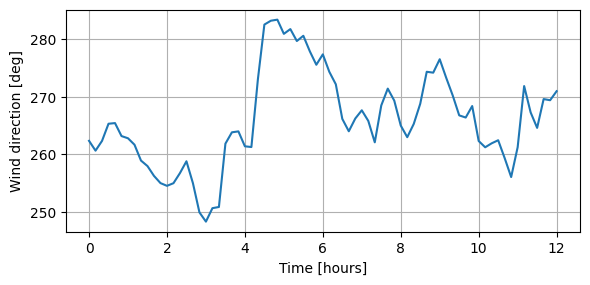

In [8]:
plt.plot(time_stamp, wd)
setup_plot(ylabel='Wind direction [deg]', xlabel='Time [hours]', figsize=(6,3))

### Constraints
#### Update interval
Changing the wind direction means that the particles need to be moved and the turbulence fields in every HAWC2 instance must be updated. Especially the turbulence field updating takes time. It is therefore recommended to only change wind direction when the turbulence fields are updated anyway. The turbulence field update interval is controlled by `hawc2WindTurbines.coupling.windfield_update_interval`, which default to 5s. 

In [9]:
update_interval = 5

#### Wind direction change
To avoid that the turbines take too big jumps, it is recommended to limit the wind direction change. For Hornsrev1 with an extend of 6.8km, a wind direction change of 0.02 deg will make the outermost turbines jump around one meter, which should be fine. In this example, the "wind farm" is small, but we will use the 0.02 deg limit to demonstrate the principle.

In [10]:
max_wd_step = 0.02

Before continuing we unwrap the wind direction signal to handle periodicity

In [11]:
wd = np.unwrap(wd,period=360) # unwrap to handle periodicity

### Slowly changing wind direction

The lower plot below shows the wind direction change pr. 5s in the selected time series as well as the limits.

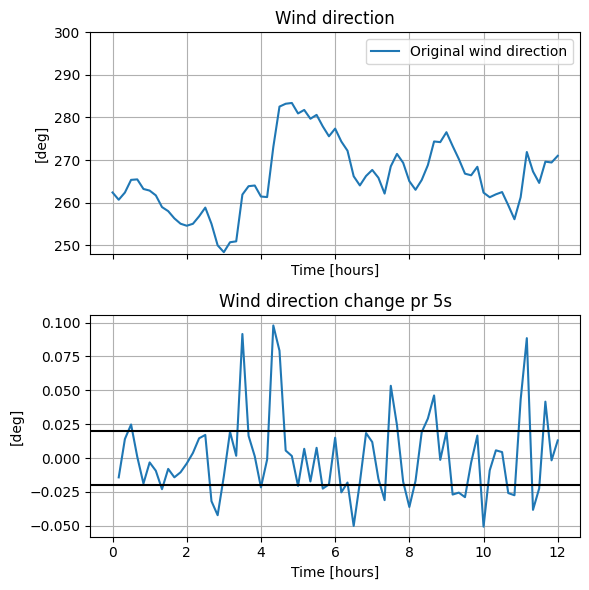

In [26]:
def plot_wd_and_change(wd_lim_lst=[]):
    ax1, ax2 = plt.subplots(2,1, figsize=(6,6), sharex=True)[1]
    ax1.plot(time_stamp, wd, label='Original wind direction')
    
    ax2.plot(time_stamp[1:], np.diff(wd) / dt * update_interval)
    for n, wd_lim in wd_lim_lst:
        rmse = np.sqrt(np.mean((wd - wd_lim)**2))
        max_e = np.abs(wd-wd_lim).max()
        ax1.plot(time_stamp, wd_lim, label=f'{n}, RMSE: {rmse:.1f}, Max err: {max_e:.1f}')
        ax2.plot(time_stamp[1:], np.diff(wd_lim) / dt * update_interval)
    for l in [-max_wd_step,max_wd_step]:
        plt.axhline(l,color='k')
    setup_plot(ax=ax1, title='Wind direction', xlabel='Time [hours]', ylabel='[deg]', ylim=[248,300])
    setup_plot(ax=ax2, title='Wind direction change pr 5s', ylabel='[deg]', xlabel='Time [hours]')

plot_wd_and_change()

As seen, some changes are larger than the limit. 

The function below returns a list of wind directions that follow the original wind directions as close a possible while limiting the wind direction changes to the specified limit.

In [13]:
def get_wd_lim(wd, dt, max_step, update_interval):
    max_step = max_step * (dt / update_interval)
    wd_lim = [wd[0]]
    for _wd in wd[1:]:
        step = np.clip(_wd - wd_lim[-1], -max_step, max_step)
        wd_lim.append(wd_lim[-1] + step)
    return wd_lim

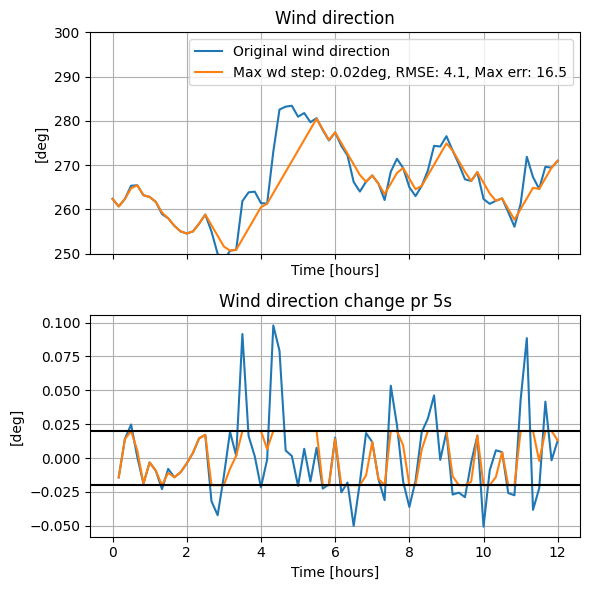

In [14]:
plot_wd_and_change([(f'Max wd step: {max_wd_step}deg', get_wd_lim(wd, dt, max_wd_step, update_interval))])

It is seen that the wind direction changes are now within the limits, but the wind direction seems to lack behind. If the full full time series is known in advance, as in this example, a better result is obtained by using the mean of the function applied forward and backward.

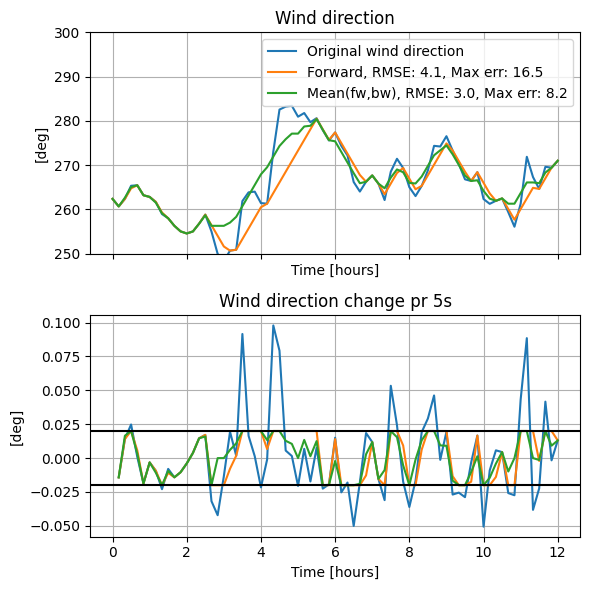

In [15]:
wd_lim_fw = get_wd_lim(wd, dt, max_wd_step, update_interval) # forward
wd_lim_bw = get_wd_lim(wd[::-1], dt, max_wd_step, update_interval)[::-1] # backward
wd_lim_mean = np.mean([wd_lim_fw,wd_lim_bw],0)
plot_wd_and_change([('Forward',wd_lim_fw), ('Mean(fw,bw)', wd_lim_mean)])    

### Remaining part with only small changes
We will now use the mean of the forward/backward method as `wd_slow` and assign the residual to `wd_small`. I.e. `wd_small` will be the wind direction relative to the turbulence transport direction (`wd_slow`)

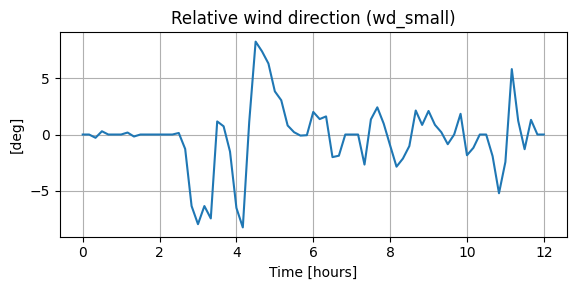

In [16]:
wd_slow = wd_lim_mean
wd_small = wd - wd_slow
plt.plot(time_stamp, wd_small)
setup_plot(title='Relative wind direction (wd_small)', ylabel='[deg]', xlabel='Time [hours]', figsize=(6,3))

### Dynamiks simulation with wind direction from met mast

We will now setup and run a simulation that uses `wd_slow` to change the turbulence transport direction `flowSimulation.wind_direction` and models the remaining part, `wd_small`, via the mean wind speed function.

In [30]:
def transport_changer(flowSimulation):
    fs = flowSimulation
    if fs.time%update_interval==0:
        fs.wind_direction = np.interp(fs.time, time, wd_slow)
        last_update=fs.time


class MyMeanWind(MeanWind):
    def __call__(self, xyz, uvw, t):
        theta = np.deg2rad(np.interp(t, time, wd_small))
        uvw[0]+=np.cos(theta)*self.ws
        uvw[1]-=np.sin(theta)*self.ws
        return uvw

site = DemoSite(ws=MyMeanWind(ws=10), ti=0.05)
wd_dumper = DataDumper(lambda fs:fs.get_wind_direction([0,0,0],include_wakes=False)) # Instant wind direction relative to the North
wd_slow_dumper = DataDumper(lambda fs:fs.wind_direction) # Turbulence transport direction
wd_small_dumper = DataDumper(lambda fs: fs.get_wind_direction([0,0,0],include_wakes=False)-fs.wind_direction) # Instant wind direction relative to turbulence transport direction

fs = DefaultDWMFlowSimulation(x=[-200,200],y=[0,0], site=site, particleMotionModel=ParticleMotionModel(temporal_filter=None),
                              d_particle=0.5, n_particles=20, 
                              dt=10, # very high dt, only for demo purposes
                              wind_direction = wd_slow[0],
                              step_handlers=[transport_changer,wd_dumper,wd_slow_dumper, wd_small_dumper])


axes = plt.subplots(2,2,figsize=(10,8))[1].flatten()
fs.run(3600*3, verbose=1)
fs.visualize(fs.time+3600*2, dt=100, interval=200, id='MeanFlowVariations_metmast',
             view=MultiView([EastNorthView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                                           flowVisualizer=Flow2DVisualizer(levels=np.linspace(-2,12,29)),
                                           visualizers=[WindDirectionVisualizer(wd_x,wd_y,70, 5), ParticleVisualizer()], ax=axes[0]),
                             XYView(z=None, x=np.linspace(-500,500),y=np.linspace(-500,500),
                                    flowVisualizer=Flow2DVisualizer(levels=np.linspace(-2,12,29)),
                                    visualizers=[WindDirectionVisualizer(wd_x,wd_y,70, 5)], ax=axes[1]),
                             View(ax=axes[2], 
                                  visualizers=[lambda fs: axes[2].plot(time,wd), 
                                               wd_dumper.get_visualizer(),
                                               wd_slow_dumper.get_visualizer(),
                                               lambda fs: axes[2].legend(['Original wind direction','Instant wind direction','Transport direction (wd_slow)'])],
                                 xlim=[0,3600*6]),
                             View(ax=axes[3], 
                                  visualizers=[lambda fs: axes[3].plot(time,wd_small), 
                                               wd_small_dumper.get_visualizer(),
                                               lambda fs: axes[3].axhline(0,ls='--',color='k'),                                                          
                                               lambda fs: axes[3].legend(['Remaing part (wd_small)','Instant relative wind direction'])],
                                  xlim=[0,3600*6],
                                  ylim=[-10,10])
                            ]))

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

### MetmastSite
The code above has been implemented in the `MetmastSite` class, which extends the `TurbulenceFieldSite`.

In [28]:
from dynamiks.sites._site import MetmastSite, NoTurbulenceField
site = MetmastSite(ws=10, turbulenceField=NoTurbulenceField(ti=.05), # no turbulence field in this example
                   wd_lst=wd, # the wind direction time series
                   dt=dt, # seconds between samples in the time series
                   max_wd_step=max_wd_step, 
                   update_interval=update_interval)

In [19]:
wd_dumper = DataDumper(lambda fs:fs.get_wind_direction([0,0,0],include_wakes=False)) # Instant wind direction relative to the North
wd_slow_dumper = DataDumper(lambda fs:fs.wind_direction) # Turbulence transport direction
# Instant wind direction relative to turbulence transport direction
wd_small_dumper = DataDumper(lambda fs: fs.get_wind_direction([0,0,0],include_wakes=False)-fs.wind_direction) 


fs = DefaultDWMFlowSimulation(x=[200],y=[0], site=site, particleMotionModel=ParticleMotionModel(temporal_filter=None),
                              dt=300, # very high dt, only for demo purposes
                              step_handlers=[wd_dumper,wd_slow_dumper, wd_small_dumper])
fs.run(3600*10, verbose=1)

  0%|          | 0/120 [00:00<?, ?it/s]

The simulated wind direction follows the prescribed original met mast measurements

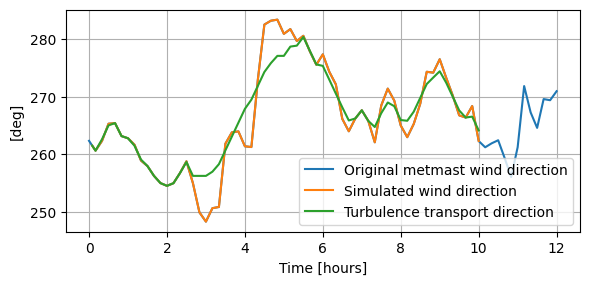

In [20]:
plt.plot(time_stamp, wd, label='Original metmast wind direction')
plt.plot(np.array(wd_dumper.time)/3600, wd_dumper.data, label='Simulated wind direction')
plt.plot(np.array(wd_slow_dumper.time)/3600, wd_slow_dumper.data, label='Turbulence transport direction')
setup_plot(xlabel='Time [hours]', ylabel='[deg]', figsize=(6,3))

The remaining part, i.e. the offset relative to the turbulence transport direction is small

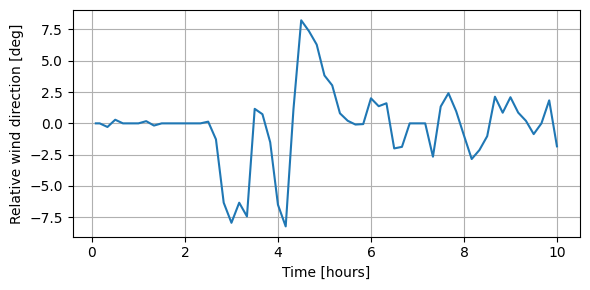

In [21]:
plt.plot(np.array(wd_small_dumper.time)/3600, wd_small_dumper.data)
setup_plot(xlabel='Time [hours]', ylabel='Relative wind direction [deg]', figsize=(6,3))

The change in turbulence transport direction pr. 5s is less than the limit of 0.02$^\circ$

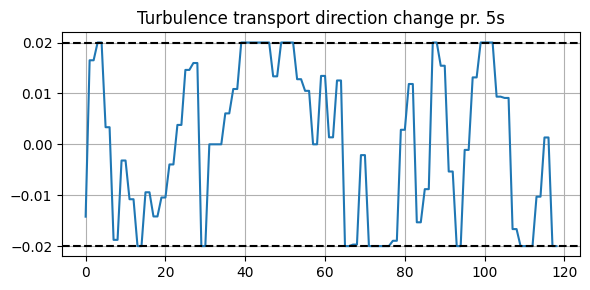

In [22]:
plt.plot(np.diff(wd_slow_dumper.to_xarray())/300*5)
for l in [-max_wd_step,max_wd_step]:
        plt.axhline(l,color='k', ls='--')
setup_plot(title='Turbulence transport direction change pr. 5s', figsize=(6,3))